In [1]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting 
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting                     


from sklearn.gaussian_process import GaussianProcessRegressor  # Gaussian Process !
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,WhiteKernel,
                                              ConstantKernel)
    

from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeavePGroupsOut
# Cross validations 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Scores
from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score  as r2                 # Metric
from sklearn.metrics import mean_squared_error as mse  

# Optimisation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 

# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 
from matplotlib import cm
np.random.seed(1338)

In [2]:
df1= pd.read_csv("Data.csv", index_col='Datetime', parse_dates=True) 
df2= pd.read_csv("Data2020.csv", index_col='Datetime', parse_dates=True)
df = pd.concat([df1,df2 ])


In [3]:
features=df
features.insert(1,"SMeanT",df.MeanT-df.SetTemp)
features.SMeanT=features.SMeanT.shift(-1)
features=features.dropna(axis=0)

In [4]:
Names=list(features.columns)
windows=list( Names[i] for i in [12,13,14,15,16,17,18,19,20,21] )  # Dataset with windows value 
features = features[ [ col for col in features.columns if col not in windows ] + windows ]
Names=list(features.columns)
unwanted = { 'group', 'WindD','SMeanT', 'WindDc','hourC','hourS', 'MeanC','Rain','SetTemp','Spa','WindDC_nan','WindDs'}
Xnames = [e for e in Names if e not in unwanted]
features['group'] = (features.index -features.index[0]).days

In [5]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 40).split(features, groups=features['group']))

Train = features.iloc[train_inds]
Test = features.iloc[test_inds]

X = Train[Xnames].values
y = Train["SMeanT"].values  
print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X_test = Test[Xnames].values
y_test = Test["SMeanT"].values  
print("X.shape:  ", X_test.shape)
print("y.shape:  ", y_test.shape)

X.shape:   (9888, 19)
y.shape:   (9888,)
X.shape:   (4007, 19)
y.shape:   (4007,)


In [6]:
not_inds, use_inds = next(GroupShuffleSplit(test_size=.3, n_splits=2, random_state = 40).split(Test, groups=Test['group']))
use = Test.iloc[use_inds]
X_use = use[Xnames].values
y_use = use["SMeanT"].values 
print("X.shape:  ", X_use.shape)
print("y.shape:  ", y_use.shape)

X.shape:   (1208, 19)
y.shape:   (1208,)


# Gussian process Optimize

In [7]:
import pickle
GP = pickle.load(open('GP_Model.sav', 'rb'))

# Optimization

In [8]:
# Function to get original value 
def weight2(x,args):
        p=np.concatenate((args,x))
        return (GP.predict(p.reshape(1, -1)))    
    
def weight(x,args):
        p=np.concatenate((args,x))
        return np.square(GP.predict(p.reshape(1, -1)))
    
# Function that gives square of prediction that has to be optimised. 

In [9]:
from pyswarm import pso          

def FindOpimumGP(GiveX):    
    
      
    lb=np.maximum([0,0,0,0,0,0,0,0], X_use[GiveX,9:17]/1.4)
    b=[max(0,X_use[GiveX,17]/1.2),max(0,X_use[GiveX,18]/1.1)]
    lb=np.append(lb, b, axis=0)

    ub= np.minimum([12.1,16,18,24.2,12.1,16,18,24.2], (X_use[GiveX,9:17]*1.4+0.1))
    c=min(X_use[GiveX,17]*1.1,17000),min(X_use[GiveX,18]*1.1,9000)
    ub=np.append(ub,c)


    args=[X_use[GiveX,[0,1,2,3,4,5,6,7,8]]]
    
    xopt, fopt = pso(weight, lb, ub, args=args, swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=300, minstep=1e-8,
    minfunc=1e-8, debug=False)
    
    OptV= weight2(xopt,X_use[GiveX,[0,1,2,3,4,5,6,7,8]])
    y_pre= weight2(X_use[GiveX,9:19],X_use[GiveX,[0,1,2,3,4,5,6,7,8]])
    y_ori= y_use[GiveX]
    return [OptV, y_pre, y_ori, xopt];

In [10]:
OpV_list=[]
y_pre_list=[]
y_ori_list=[]
x_opt_list=[]
x=np.arange(0,len(X_use)-1)

for i in x:
    OpV, y_pre, y_ori,xopt = FindOpimumGP(i)
    OpV_list = np.append(OpV_list, [OpV])
    y_pre_list = np.append(y_pre_list, [y_pre])
    y_ori_list = np.append(y_ori_list, [y_ori])
    x_opt_list = np.append(x_opt_list, [xopt])

Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Sto

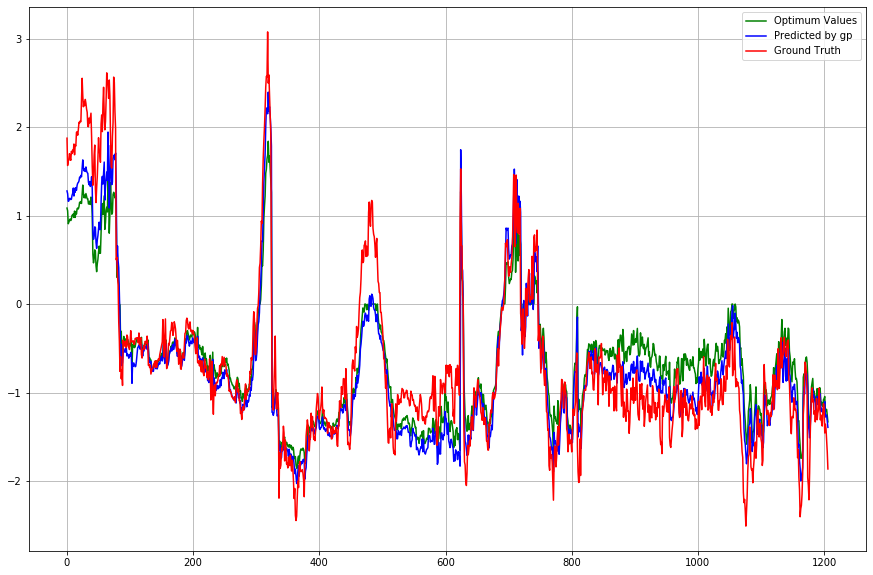

In [11]:
plt.figure(figsize=(15,10))
plt.plot(OpV_list,'g',label='Optimum Values')
plt.plot(( y_pre_list),'b',label='Predicted by gp')
plt.plot((y_ori_list),'r',label='Ground Truth')
plt.legend()
plt.grid()

In [12]:
A=np.array([[OpV_list],[y_pre_list],[y_ori_list] ])
A=np.squeeze(A)
A=np.transpose(A)
print(A.shape)
A=np.append(A, np.reshape(x_opt_list,[len(x),10]), axis=1)
print(A.shape)
np.savetxt("GP_Model.csv", A, delimiter=',', header="Optimum,Prediction,GroundTruth,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10", comments="")

(1207, 3)
(1207, 13)


In [13]:
OptimumX=np.reshape(x_opt_list,[len(x),10])
OptimumX.shape

(1207, 10)

In [14]:
OptimumX.shape

(1207, 10)

In [15]:
OriginalX=use[Xnames[9:19]] # get original X

In [16]:
OptimumX=pd.DataFrame(OptimumX,columns=Xnames[9:19])
OptimumX['Datetime']=OriginalX.index[:-1]                       # Make dataframe of optimum X
OptimumX.set_index('Datetime', inplace=True)

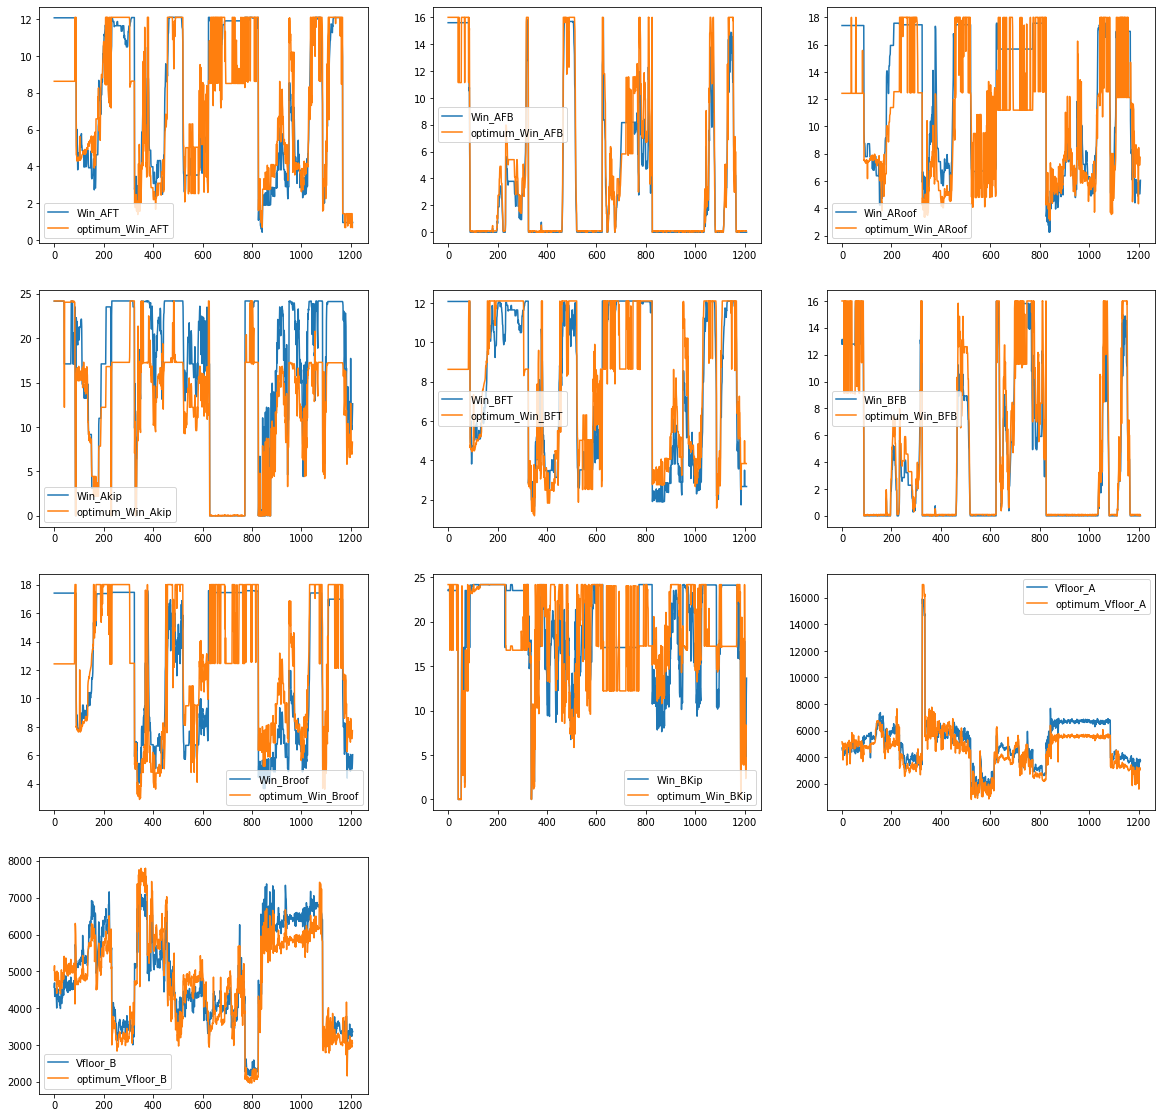

In [17]:

plt.figure(figsize=(20,20))
for i, col in enumerate(OriginalX.columns):
    plt.subplot(4,3,i+1)
    plt.plot(OriginalX[col].values, label=col)
    plt.plot(OptimumX[col].values, label='optimum_'+col)
    plt.legend(loc='best')
plt.show()